# Demonstration for the pipeline of RPN and GCVIT

## Imports

In [2]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform, get_transform
# from project.preprocessing import z_score_normalization, min_max_normalization
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.rpn_to_gcvit import RPN_to_GCVIT


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the masks and cases

In [3]:
ds = Dataset()

In [4]:
masks = ds.load_cmb_masks()
cases = ds.load_skullstripped_mri()

In [5]:
transform = NiftiToTensorTransform(target_shape=(512,512))

## Generate the dataset that will be used for the demonstration

In [6]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

### Number of masks

In [7]:
print(masks.__len__())

72


## Create the sample data for the demonstration

In [8]:
import nibabel as nib
import numpy as np

bbox_list = []

for i in range(masks.__len__()):
    ann = nib.load(masks[i]).get_fdata() # Load the image of mask
    ann = (ann > 0).astype(np.uint8)
    print(f'\nProcessing case: {i}')

    # Dictionary for the current case
    slice_bbox = {
        'case': masks[i],
        'bbox': []
    }

    for j in range(ann.shape[2]):
        bbox = dataset.extract_bounding_boxes(ann[:, :, j]) # Get the bounding box of the current slice
        slice_bbox['bbox'].append(bbox)
        print(f'Slice: {j}, count: {bbox.__len__()}')
    bbox_list.append(slice_bbox) # Append to the bbox_list

# Notification only
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)


Processing case: 0
Slice: 0, count: 0
Slice: 1, count: 0
Slice: 2, count: 0
Slice: 3, count: 0
Slice: 4, count: 0
Slice: 5, count: 0
Slice: 6, count: 0
Slice: 7, count: 0
Slice: 8, count: 2
Slice: 9, count: 1
Slice: 10, count: 0
Slice: 11, count: 1
Slice: 12, count: 2
Slice: 13, count: 0
Slice: 14, count: 0
Slice: 15, count: 1
Slice: 16, count: 5
Slice: 17, count: 2
Slice: 18, count: 0
Slice: 19, count: 0
Slice: 20, count: 0
Slice: 21, count: 0
Slice: 22, count: 0
Slice: 23, count: 0
Slice: 24, count: 0
Slice: 25, count: 0
Slice: 26, count: 0
Slice: 27, count: 1
Slice: 28, count: 0
Slice: 29, count: 0
Slice: 30, count: 0
Slice: 31, count: 0
Slice: 32, count: 0
Slice: 33, count: 0
Slice: 34, count: 0

Processing case: 1
Slice: 0, count: 0
Slice: 1, count: 0
Slice: 2, count: 0
Slice: 3, count: 0
Slice: 4, count: 0
Slice: 5, count: 0
Slice: 6, count: 0
Slice: 7, count: 0
Slice: 8, count: 0
Slice: 9, count: 0
Slice: 10, count: 0
Slice: 11, count: 0
Slice: 12, count: 0
Slice: 13, count: 0


In [9]:
bbox_list

[{'case': 'c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\Thesis_Folder\\Dataset\\VALDO_dataset\\cmb_masks_dir\\sub-101_space-T2S_CMB.nii.gz',
  'bbox': [[],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [[164, 327, 172, 336], [180, 299, 184, 303]],
   [[257, 320, 260, 324]],
   [],
   [[278, 345, 281, 348]],
   [[233, 321, 237, 324], [259, 313, 263, 317]],
   [],
   [],
   [[155, 188, 160, 192]],
   [[267, 301, 271, 306],
    [264, 294, 268, 299],
    [271, 292, 276, 296],
    [268, 220, 273, 226],
    [259, 216, 262, 220]],
   [[268, 288, 279, 299], [271, 226, 275, 230]],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [[254, 303, 258, 308]],
   [],
   [],
   [],
   [],
   [],
   [],
   []]},
 {'case': 'c:\\Users\\Lex Zedrick Lorenzo\\Documents\\GitHub\\Thesis_Folder\\Dataset\\VALDO_dataset\\cmb_masks_dir\\sub-102_space-T2S_CMB.nii.gz',
  'bbox': [[],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
 

## Initialize the connector and pass the bbox_list and the patch_size 

In [13]:
connector = RPN_to_GCVIT(
    b_boxes=bbox_list,
    patch_size=(16, 16)
)

## Number of cases

In [19]:
connector.__len__()

572

## Display the list of bounding boxes

In [18]:
import pandas as pd

bbox_df = pd.DataFrame(connector.all_bbox)

bbox_df

,case,slice_num,bbox
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,"[160, 324, 176, 340]"
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,"[174, 293, 190, 309]"
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,"[251, 314, 267, 330]"
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,"[272, 339, 288, 355]"
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,"[227, 315, 243, 331]"
...,...,...,...
567,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,"[140, 147, 156, 163]"
568,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,"[139, 146, 155, 162]"
569,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,"[185, 133, 201, 149]"
570,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,"[185, 132, 201, 148]"


## Print all the cases where the bboc coordinates does not match the patch_size

In [20]:
for i in range(connector.__len__()):
    bbox = connector[i]["bbox"]
    prev_width = abs(bbox[0] - bbox[2])
    prev_height = abs(bbox[1] - bbox[3])
    if prev_height != 16 | prev_width != 16:
        print(connector[i])

## Resize function for the cropped images

In [14]:
resize = get_transform(
    height=100,
    width=100,
    p=1.0
)

## Get the cropped image and labes and plot them

torch.Size([35, 1, 1, 512, 512])


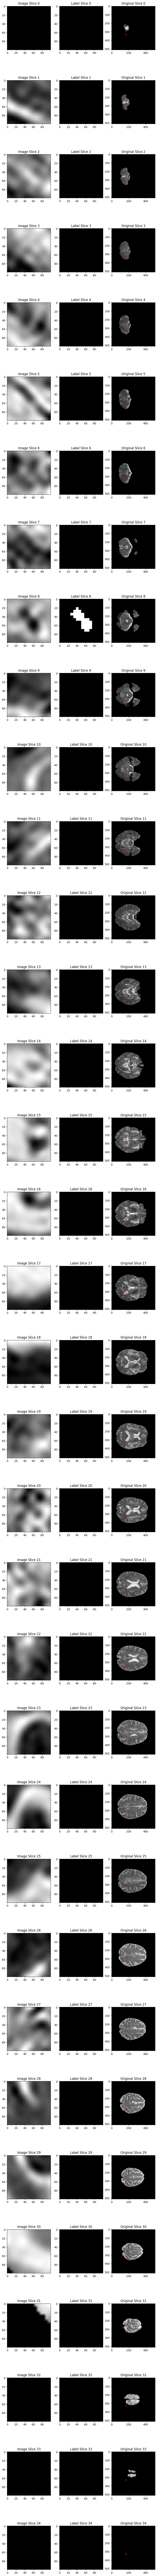

KeyboardInterrupt: 

In [15]:
import matplotlib.patches as patches

for i in range(connector.__len__()):
    x = connector[i] # b_box
    img = dataset.locate_case_by_name(x['case']) # find the case of the img

    bbox = x['bbox']

    # Get the cropped image and labels
    cropped_img = connector.get_cropped_locations(img[0], x['bbox'])
    cropped_label = connector.get_cropped_locations(img[1], x['bbox'])
    
    num_slices = cropped_img.shape[2] # Number of slices

    # Figure with numslices as rows and 2 columns
    fig, ax = plt.subplots(num_slices, 3, figsize=(10, num_slices * 5))

    print(img[0].shape)

    for j in range(num_slices):
        # resize the image and label
        augmented_img = resize(
            image=cropped_img[0, 0, j].numpy(),
            mask=cropped_label[0, j].numpy()
        )

        img_slice = augmented_img['image']
        label_slice = augmented_img['mask']
        
        
        # Plot image in 1st column
        ax[j, 0].imshow(img_slice[0], cmap='gray')
        ax[j, 0].set_title(f'Image Slice {j}')
        
        # Plot label in secondf column
        ax[j, 1].imshow(label_slice, cmap='gray')
        ax[j, 1].set_title(f'Label Slice {j}')

        # Plot label in secondf column
        ax[j, 2].imshow(img[0][j][0, 0, :], cmap='gray')
        ax[j, 2].set_title(f'Original Slice {j}')

        # Create the bounding box rectangle
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),  # (x_min, y_min)
            bbox[2] - bbox[0],   # width
            bbox[3] - bbox[1],   # height
            linewidth=1, edgecolor='r', facecolor='none'  # red bounding box
        )

        # Add the rectangle to the axis
        ax[j, 2].add_patch(rect)

    plt.show()
    
    # Break if i matches your desired number of plotted case
    if i == 10:
        break